In [4]:
import pandas as pd
from pathlib import Path
import re
import string
import json
import seaborn as sns
import numpy as np
from collections import defaultdict
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
import urllib.request
from matplotlib import pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords

import xml.etree.ElementTree as et 

[nltk_data] Downloading package punkt to /Users/arinaruck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arinaruck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
DATA_FOLDER = Path('/Users/arinaruck/Desktop/courses/ADA2022/Project/data')
CORENLP_DATA = DATA_FOLDER / 'corenlp_plot_summaries'
SUMMARY_DATA = DATA_FOLDER / 'MovieSummaries'

In [6]:
characters = pd.read_csv(SUMMARY_DATA / 'character.metadata.tsv', sep='\t', header=None)
characters.head()

0          1           2                           3           4  5   \
0  975900  /m/03vyhn  2001-08-24                    Akooshay  1958-08-26  F   
1  975900  /m/03vyhn  2001-08-24  Lieutenant Melanie Ballard  1974-08-15  F   
2  975900  /m/03vyhn  2001-08-24         Desolation Williams  1969-06-15  M   
3  975900  /m/03vyhn  2001-08-24          Sgt Jericho Butler  1967-09-12  M   
4  975900  /m/03vyhn  2001-08-24             Bashira Kincaid  1977-09-25  F   

      6           7                   8     9           10          11  \
0  1.620         NaN      Wanda De Jesus  42.0  /m/0bgchxw  /m/0bgcj3x   
1  1.780  /m/044038p  Natasha Henstridge  27.0   /m/0jys3m  /m/0bgchn4   
2  1.727     /m/0x67            Ice Cube  32.0   /m/0jys3g  /m/0bgchn_   
3  1.750         NaN       Jason Statham  33.0  /m/02vchl6  /m/0bgchnq   
4  1.650         NaN         Clea DuVall  23.0  /m/02vbb3r  /m/0bgchp9   

           12  
0  /m/03wcfv7  
1   /m/0346l4  
2  /m/01vw26l  
3   /m/034hyc  
4   /m/01y9xg

In [7]:
column_names = ['wiki_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']
movies = pd.read_csv(SUMMARY_DATA / 'movie.metadata.tsv', sep='\t', header=None, names=column_names, index_col='wiki_movie_id')


for col in ['movie_languages', 'movie_countries', 'movie_genres']:
    movies[col] = movies[col].apply(json.loads)

# dates fixes
ids_to_release_dates = {29666067: '2010-12-02', 30049059: '1981-12-25', 18631737: '1911-12-01', 27883510: '1918-07-14'}
for id, release_date in ids_to_release_dates.items():
    movies.loc[id, 'movie_release_date']= release_date


movies['movie_release_date'] = pd.to_datetime(movies.movie_release_date)
movies['year'] = [year.year for year in movies['movie_release_date']]
movies.head()

freebase_movie_id  \
wiki_movie_id                     
975900                /m/03vyhn   
3196793               /m/08yl5d   
28463795             /m/0crgdbh   
9363483              /m/0285_cd   
261236                /m/01mrr1   

                                                      movie_name  \
wiki_movie_id                                                      
975900                                            Ghosts of Mars   
3196793        Getting Away with Murder: The JonBenét Ramsey ...   
28463795                                             Brun bitter   
9363483                                         White Of The Eye   
261236                                         A Woman in Flames   

              movie_release_date  movie_revenue  movie_runtime  \
wiki_movie_id                                                    
975900                2001-08-24     14010832.0           98.0   
3196793               2000-02-16            NaN           95.0   
28463795              1988-01-01            NaN           83.0   
9363483               1987-01-01            NaN          110.0   
261236                1983-01-01            NaN          106.0   

                                  movie_languages  \
wiki_movie_id                                       
975900         {'/m/02h40lc': 'English Language'}   
3196793        {'/m/02h40lc': 'English Language'}   
28463795       {'/m/05f_3': 'Norwegian Language'}   
9363483        {'/m/02h40lc': 'English Language'}   
261236          {'/m/04306rv': 'German Language'}   

                                         movie_countries  \
wiki_movie_id                                              
975900         {'/m/09c7w0': 'United States of America'}   
3196793        {'/m/09c7w0': 'United States of America'}   
28463795                          {'/m/05b4w': 'Norway'}   
9363483                   {'/m/07ssc': 'United Kingdom'}   
261236                           {'/m/0345h': 'Germany'}   

                                                    movie_genres    year  
wiki_movie_id                                                             
975900         {'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...  2001.0  
3196793        {'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...  2000.0  
28463795       {'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...  1988.0  
9363483        {'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...  1987.0  
261236                                   {'/m/07s9rl0': 'Drama'}  1983.0

In [103]:
movies[movies.movie_countries.apply(lambda x: 'Nazi Germany' in x.values() )]

freebase_movie_id  \
wiki_movie_id                     
21234681             /m/05c4_y9   
6906953               /m/0gwhf1   
1970651               /m/069ycr   
2728728               /m/07_dfx   
26749011             /m/0bm8t1b   
185874                /m/019djy   
34002384             /m/0hr5h_n   
26762611             /m/0bmftcp   
6969350               /m/0gz8pr   
10264475             /m/02q6xgq   
9126115              /m/027ymc4   
6101136               /m/0fq50n   
26273295             /m/0b74rbm   
30039                  /m/07d75   
6615637               /m/0gdwhw   
14474699             /m/03d4qh_   
11375826             /m/02r9dws   
10376736             /m/02q9vkd   
797363                /m/03cv5k   
2974554               /m/08h2g_   
8475350              /m/0274ttw   
6970599               /m/0gz9pb   
36057315             /m/0j_57_0   

                                                      movie_name  \
wiki_movie_id                                                      
21234681                                                 Jud Süß   
6906953        Of the Little Tree Which Wished for Different ...   
1970651                                           Der ewige Jude   
2728728                                                Morgenrot   
26749011                                              Friesennot   
185874                                       Verwitterte Melodie   
34002384            Friedrich Schiller - The Triumph of a Genius   
26762611                                       The Private's Job   
6969350                                                 Heimkehr   
10264475                                          Sieg im Westen   
9126115                                      Festliches Nürnberg   
6101136                                          S.A.-Mann Brand   
26273295                                                Das Erbe   
30039                                        Triumph of the Will   
6615637                                   Marsch zum Führer, Der   
14474699                                           Wunschkonzert   
11375826                        Kampf um Norwegen - Feldzug 1940   
10376736                                    Carnival in Flanders   
797363                                                   Olympia   
2974554                       Tag der Freiheit: Unsere Wehrmacht   
8475350                                                Fugitives   
6970599                                             Wort und Tat   
36057315                                               Pygmalion   

              movie_release_date  movie_revenue  movie_runtime  \
wiki_movie_id                                                    
21234681              1940-01-01            NaN           98.0   
6906953               1940-01-01            NaN            7.0   
1970651               1940-01-01            NaN           62.0   
2728728               1933-02-02            NaN           75.0   
26749011              1935-01-01            NaN           97.0   
185874                1943-01-01            NaN           10.0   
34002384              1940-01-01            NaN           98.0   
26762611              1937-09-07            NaN           82.0   
6969350               1941-01-01            NaN           96.0   
10264475              1941-01-01            NaN          114.0   
9126115               1937-01-01            NaN           21.0   
6101136               1933-01-01            NaN           94.0   
26273295              1935-01-01            NaN            NaN   
30039                 1934-01-01            NaN          115.0   
6615637               1940-01-01            NaN           45.0   
14474699              1940-12-30            NaN          103.0   
11375826              2006-09-22            NaN           80.0   
10376736              1935-12-03            NaN           95.0   
797363                1938-01-01            NaN          111.0   
2974554               1935-12-30            NaN    

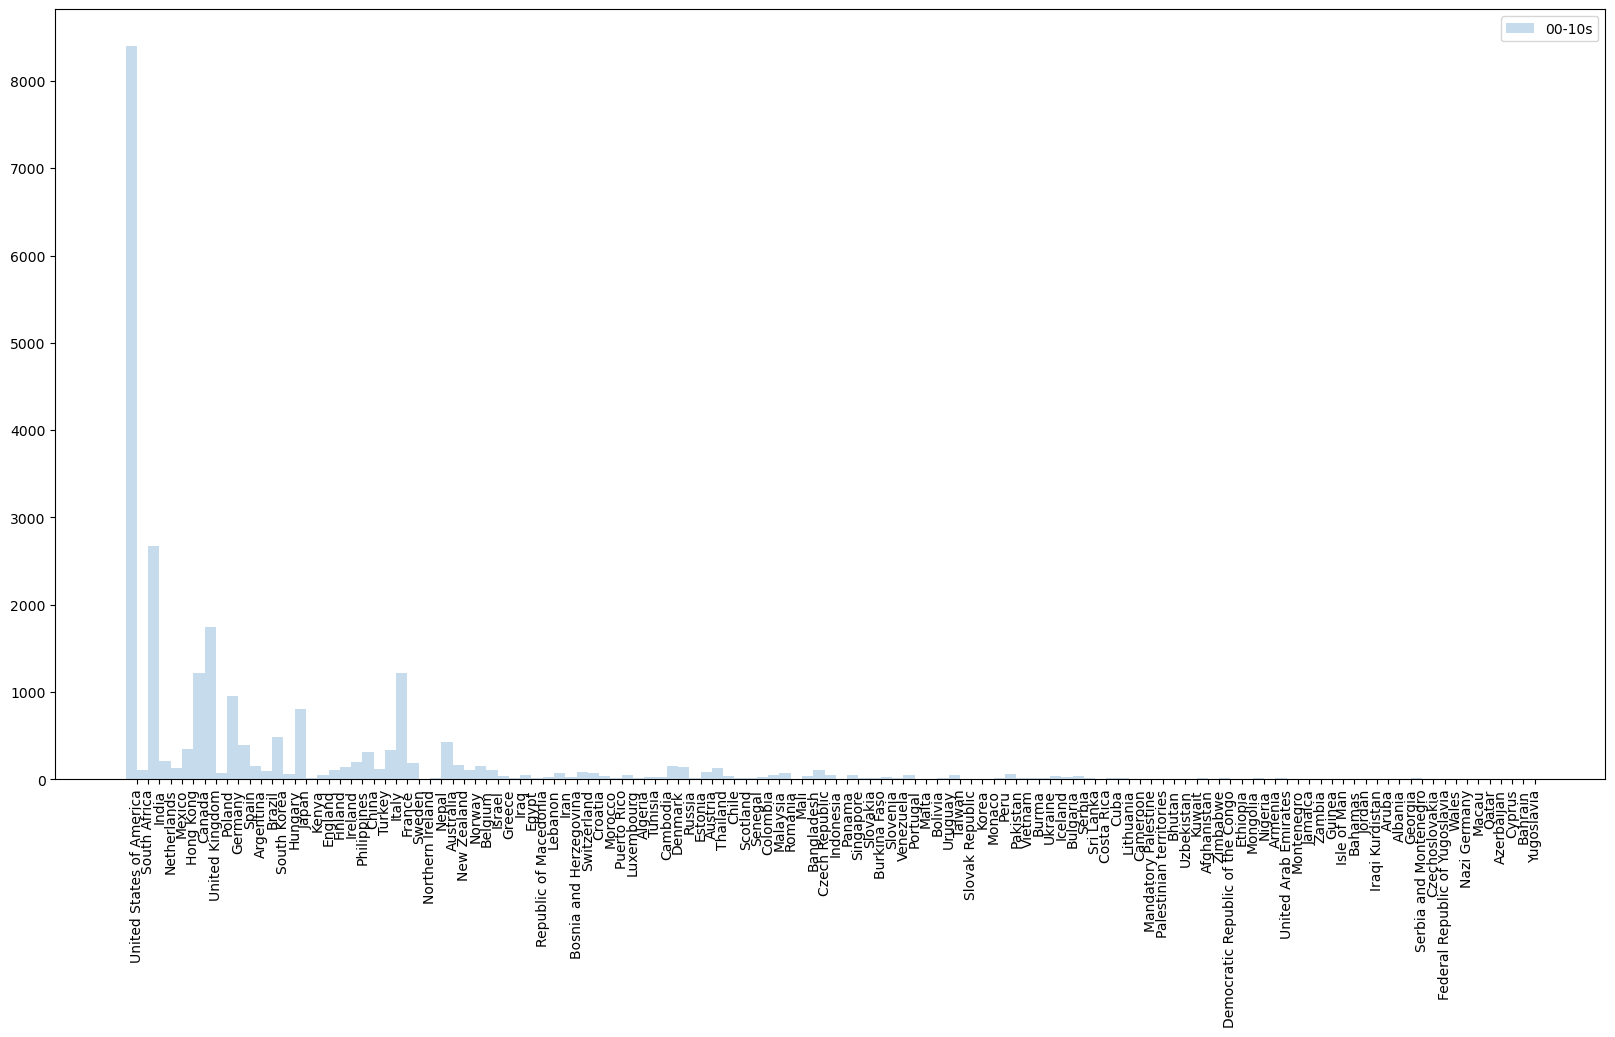

"\nplt.figure(figsize=(20, 10))\nmovies_old = movies[(movies['year'] <= 2000) & (movies['year'] > 1984)]\ncountries = []   \nfor _, movie_countries in movies_old.movie_countries.iteritems():\n    countries.extend(list(movie_countries.values()))\n\nplt.hist(countries, bins=len(set(countries)));\n#plt.yscale('log')\nplt.tick_params(axis='x', rotation=45 * 2)\nplt.xticks();\nplt.show()\n"

In [90]:
from cProfile import label
from collections import Counter

plt.figure(figsize=(20, 10))
#plt.yscale('log')
width = 1
alpha = 0.25

movies_new = movies[(movies['year'] > 2000) & (movies['year'] <= 2010)]
print(movies_new[movies_new['countries']])
countries = []   
for _, movie_countries in movies_new.movie_countries.iteritems():
    countries.extend(list(movie_countries.values()))

countries_cnt = Counter(countries)
labels, values = zip(*countries_cnt.items())
indexes = np.arange(len(labels))

plt.bar(indexes, values, width, alpha=alpha, label='00-10s')
plt.xticks(indexes + width * 0.5, labels)
plt.tick_params(axis='x', rotation=45 * 2)

'''
movies_old = movies[(movies['year'] <= 2000) & (movies['year'] > 1990)]
countries = []   
for _, movie_countries in movies_old.movie_countries.iteritems():
    countries.extend(list(movie_countries.values()))

countries_cnt = Counter(countries)
labels, values = zip(*countries_cnt.items())
indexes = np.arange(len(labels))

plt.bar(indexes, values, width, alpha=alpha, label='90-00s')


movies_older = movies[(movies['year'] > 1980) & (movies['year'] <= 1990)]
countries = []   
for _, movie_countries in movies_older.movie_countries.iteritems():
    countries.extend(list(movie_countries.values()))

countries_cnt = Counter(countries)
labels, values = zip(*countries_cnt.items())
indexes = np.arange(len(labels))
plt.bar(indexes, values, width, alpha=alpha, label='80-90s')



movies_oldest = movies[(movies['year'] <= 1980) & (movies['year'] > 1970)]
countries = []   
for _, movie_countries in movies_oldest.movie_countries.iteritems():
    countries.extend(list(movie_countries.values()))

countries_cnt = Counter(countries)
labels, values = zip(*countries_cnt.items())
indexes = np.arange(len(labels))
plt.bar(indexes, values, width, alpha=alpha, label='70-80s')
'''

plt.legend()
plt.show()

#plt.show()

#ax = plt.bar(countries, bins=len(set(countries)));
#plt.yscale('log')

'''
plt.figure(figsize=(20, 10))
movies_old = movies[(movies['year'] <= 2000) & (movies['year'] > 1984)]
countries = []   
for _, movie_countries in movies_old.movie_countries.iteritems():
    countries.extend(list(movie_countries.values()))

plt.hist(countries, bins=len(set(countries)));
#plt.yscale('log')
plt.tick_params(axis='x', rotation=45 * 2)
plt.xticks();
plt.show()
'''

In [49]:
print(len(movies))
movies[~movies.movie_countries.apply(lambda x: '/m/09c7w0' in x )].describe()


81741


movie_revenue  movie_runtime          year
count   1.465000e+03   31782.000000  41642.000000
mean    1.706687e+07      99.811786   1980.325249
std     3.888727e+07     114.876895     26.740413
min     1.000000e+04       0.030000   1888.000000
25%     1.186742e+06      85.000000   1962.000000
50%     4.912892e+06      96.000000   1986.000000
75%     1.501402e+07     112.000000   2004.000000
max     5.525261e+08   14400.000000   2016.000000

In [31]:
movies[~movies['year'].isna()][['movie_genres', 'year']][:5]

movie_genres    year
wiki_movie_id                                                           
975900         {'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...  2001.0
3196793        {'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...  2000.0
28463795       {'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...  1988.0
9363483        {'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...  1987.0
261236                                   {'/m/07s9rl0': 'Drama'}  1983.0

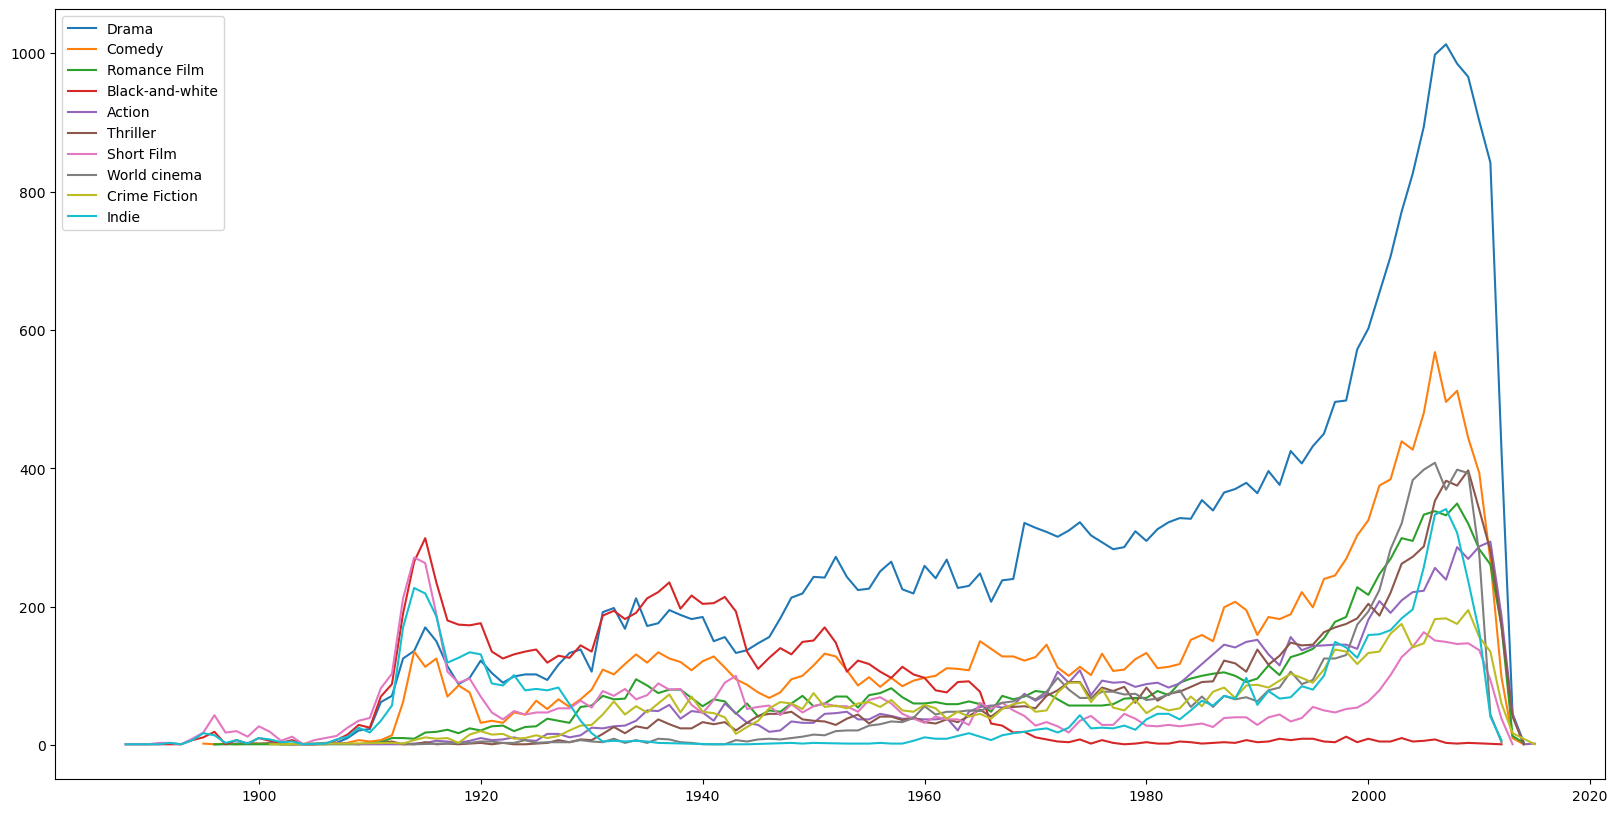

In [38]:
plt.figure(figsize=(20, 10))

genres_cnt = Counter(genres_flat)
top_n = 10
top_n_genres = [genre for genre, _ in genres_cnt.most_common(n=top_n)]

genre_year_to_cnt = {genre: defaultdict(int) for genre in top_n_genres}
genres_n_years = movies[~movies['year'].isna() & (movies['year'] < 2016)][['movie_genres', 'year']]
for movie_genres, year in genres_n_years.values:
    if not year or not movie_genres:
        continue 
    movie_genres = movie_genres.values()
    for genre in movie_genres:
        if genre in top_n_genres:
            genre_year_to_cnt[genre][year] += 1
for genre, year_to_cnt in genre_year_to_cnt.items():
    year_n_count = list(year_to_cnt.items())
    year_n_count.sort(key=lambda x: x[0])
    years, counts = [el[0] for el in year_n_count], [el[1] for el in year_n_count]
    plt.plot(years, counts, label=genre)
plt.legend()
plt.show()


            
            

In [9]:
genres_n_years.values

array([[{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science Fiction', '/m/03npn': 'Horror', '/m/03k9fj': 'Adventure', '/m/0fdjb': 'Supernatural', '/m/02kdv5l': 'Action', '/m/09zvmj': 'Space western'},
        2001.0],
       [{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biographical film', '/m/07s9rl0': 'Drama', '/m/0hj3n01': 'Crime Drama'},
        2000.0],
       [{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'Drama'}, 1988.0],
       ...,
       [{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}, 1972.0],
       [{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': 'Japanese Movies', '/m/03k9fj': 'Adventure', '/m/0hcr': 'Animation', '/m/02hmvc': 'Short Film', '/m/0jxy': 'Anime', '/m/07s9rl0': 'Drama'},
        1992.0],
       [{'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror', '/m/01585b': 'Slasher', '/m/02b5_l': 'Teen'},
        2002.0]], dtype=object)

In [201]:
movies.year.describe()

count    74839.000000
mean      1977.488248
std         28.886690
min       1888.000000
25%       1956.000000
50%       1985.000000
75%       2004.000000
max       2016.000000
Name: year, dtype: float64

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

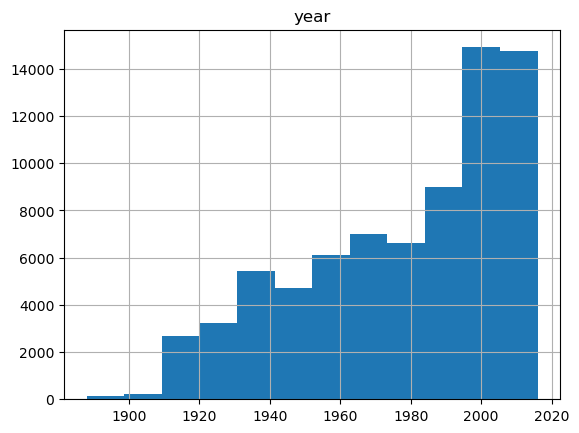

In [206]:
movies.hist('year', bins=12)

In [102]:
movie_ids = set(movies.index)
plot_ids = set()
with open(SUMMARY_DATA / 'plot_summaries.txt', 'r') as f:
   for line in f:
    plot_ids.add(int(line.split('\t')[0]))
print(f'Movies in movie table: {len(movie_ids)}, plot summaries: {len(plot_ids)}, intersection: {len(movie_ids.intersection(plot_ids))}')

Movies in movie table: 81741, plot summaries: 42306, intersection: 42207


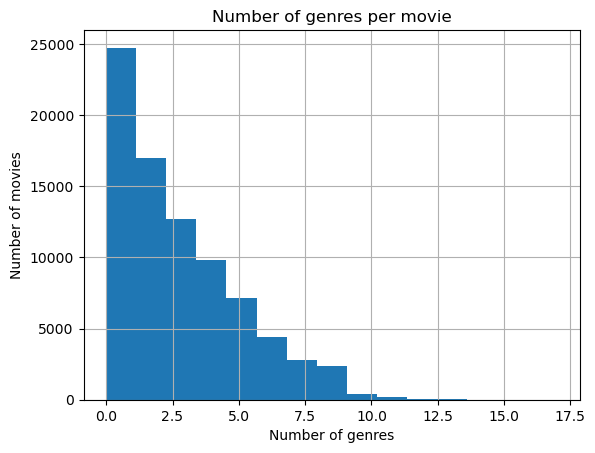

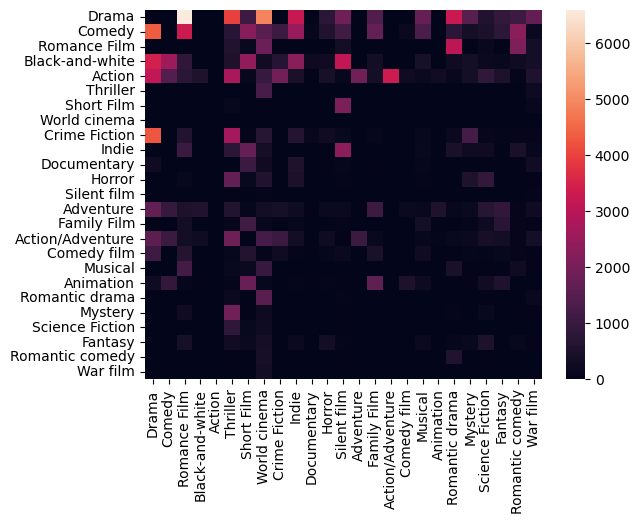

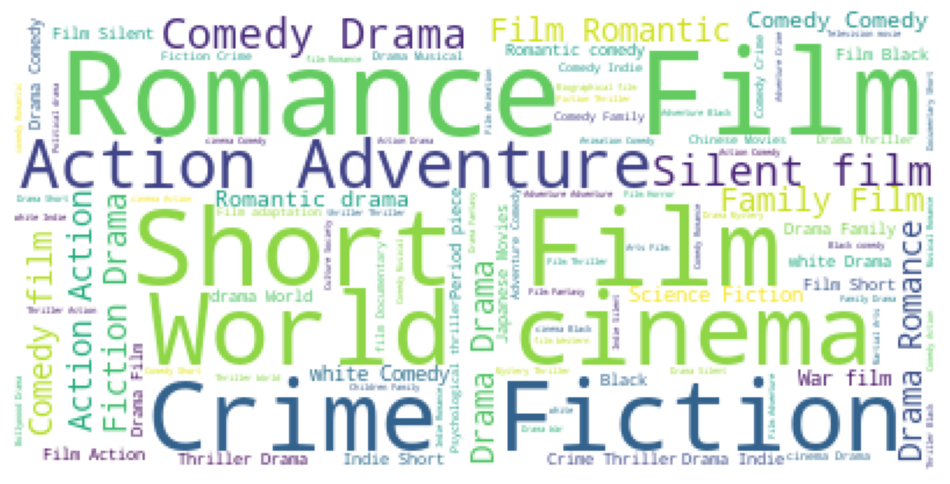

In [10]:
from typing import Counter


genres = movies['movie_genres']
genres.str.len().hist(bins=15)
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.title('Number of genres per movie');
plt.show()

genres_flat = []
genres_cooc = defaultdict(int)
for movie_genres in genres.values:
    movie_genres = sorted(list(movie_genres.values()))
    genres_flat += movie_genres
    n_genres = len(movie_genres)
    for i in range(n_genres):
        for j in range(i + 1, n_genres):
            genres_cooc[(movie_genres[i], movie_genres[j])] += 1

genres_cnt = Counter(genres_flat)
top_n = 25
top_n_genres = [genre for genre, _ in genres_cnt.most_common(n=top_n)]
cooc_mtx = np.zeros((top_n, top_n))
for i, genre_a in enumerate(top_n_genres):
    for j, genre_b, in enumerate(top_n_genres):
        cooc_mtx[i][j] = genres_cooc[(genre_a, genre_b)]


ax = sns.heatmap(cooc_mtx, yticklabels=top_n_genres, xticklabels=top_n_genres);

wordcloud = WordCloud(background_color="white").generate(' '.join(genres_flat))
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show()

In [211]:
re.escape(string.punctuation)

PUNCT = re.compile(rf'[{re.escape(string.punctuation)}]')
STOPWORDS = stopwords.words("english")
STOPWORDS.extend(['one', 'two', 'three', 'four', 'five'])

def tokenize(texts):
    text = '\n'.join(texts).lower()
    words = [word for word in word_tokenize(text) if word not in STOPWORDS]
    return words


Skipped: 130


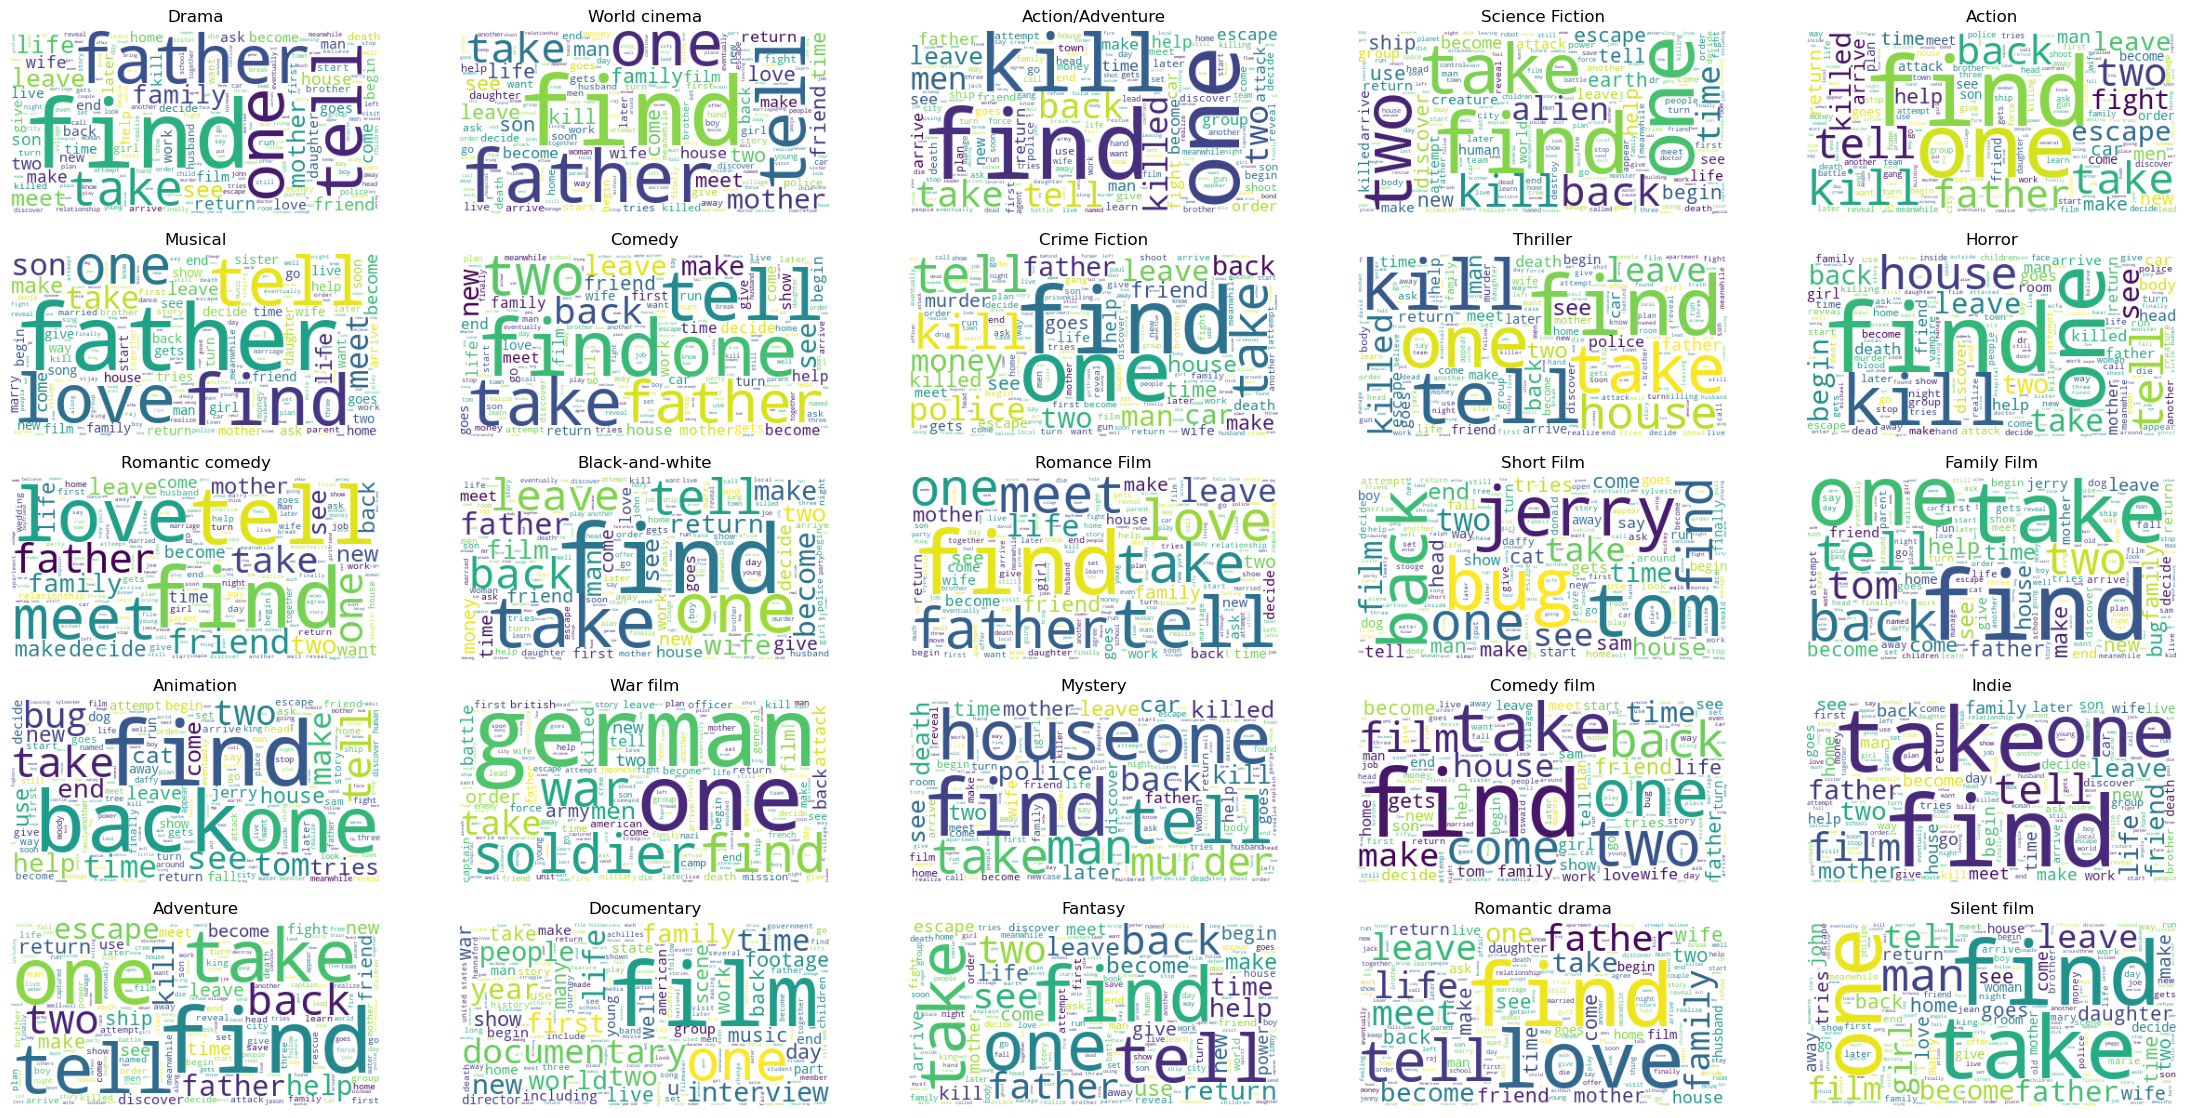

In [210]:
plots = []
skipped = 0
genres = movies['movie_genres']
genre_to_plot = defaultdict(list)
with open(SUMMARY_DATA / 'plot_summaries.txt', 'r') as f:
    for i, line in enumerate(f):
        id, plot = line.split('\t')
        plot_genres = genres.get(int(id))
        if i > 10000:
            break
        if not plot_genres:
            skipped += 1
            continue
        plot_text = re.sub(PUNCT, ' ', plot)
        for _, genre in plot_genres.items():
            if genre in top_n_genres:
                genre_to_plot[genre].append(plot_text)
        plots.append(plot_text)

    words = tokenize(plots)

side = 5
fig, axes = plt.subplots(side, side, figsize=(28, 14))
for num, genre in enumerate(genre_to_plot):
    i, j = num // side, num % side
    words = tokenize(genre_to_plot[genre])
    wordcloud = WordCloud(background_color="white").generate(' '.join(words))
    axes[i][j].imshow(wordcloud)
    axes[i][j].axis('off')
    axes[i][j].set_title(genre)



print(f'Skipped: {skipped}')

In [ ]:
all_words = sum(words, [])
fdist = FreqDist(all_words)
fdist.most_common(10)

In [56]:
for file in CORENLP_DATA.iterdir():
    xtree = et.parse(file)
    xroot = xtree.getroot()
    for sentence in xroot.findall(r'[sentence]'):
        print(sentence)
    break

In [36]:
!cat /Users/arinaruck/Desktop/courses/ADA2022/Project/data/corenlp_plot_summaries/30843639.xml

<?xml version="1.0" encoding="UTF-8"?>
<?xml-stylesheet href="CoreNLP-to-HTML.xsl" type="text/xsl"?>
<root>
  <document>
    <sentences>
      <sentence id="1">
        <tokens>
          <token id="1">
            <word>In</word>
            <lemma>in</lemma>
            <CharacterOffsetBegin>0</CharacterOffsetBegin>
            <CharacterOffsetEnd>2</CharacterOffsetEnd>
            <POS>IN</POS>
            <NER>O</NER>
          </token>
          <token id="2">
            <word>Los</word>
            <lemma>Los</lemma>
            <CharacterOffsetBegin>3</CharacterOffsetBegin>
            <CharacterOffsetEnd>6</CharacterOffsetEnd>
            <POS>NNP</POS>
            <NER>LOCATION</NER>
          </token>
          <token id="3">
            <word>Angeles</word>
            <lemma>Angeles</lemma>
            <CharacterOffsetBegin>7</CharacterOffsetBegin>
            <CharacterOffsetEnd>14</CharacterOffsetEnd>
            <POS>NNP</POS>
            <NER>LOCATION</NER>
          <